<a href="https://colab.research.google.com/github/AASCP/MVP_PUC-Rio/blob/main/MVP_aascp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - PRECIFICAÇÃO DE VALOR DE MERCADO JOGADORES DE FUTEBOL**
### Antonio Adolpho Pereira

# 1. Definição do Problema

Segundo dados da FIFA (Fédération Internationale de Football Association), o futebol mundial transaciona anualmente cifras significativas, chegando a  US$286 bilhões. Estes valores estão concentrados em clubes do continente europeu e são equivalentes ao Produto Interno Bruno da Finlândia (49º no ranking mundial, segundo projeções do Banco Mundial).

A UEFA (Union of European Football Associations), por sua vez, diante do expressivo aumento dos custos necessários para se competir nas principais ligas mundiais, e objetivando tanto melhorar a condição financeira dos clubes de futebol e quanto tornar o mercado como um todo mais estável e sólido, criou uma regulamentação que ficou conhecida como Fair Play Financeiro.

Diante disto, a montagem de equipes profissionais que sejam simultaneamente competitivas e respeitem os limites financeiros estabelecidos torna-se um desafio em que os processos relacionados à correta valoração dos atletas profissionais passam a ganhar destaque na criação de valor para os clubes profissionais.

Isto posto, o objetivo deste trabalho é prever se um jogador de futebol profissional está subvalorizado, corretamente precificado ou supervalorizado, com base em um conjunto de atributos pessoais, do clube a qual pertence. Para isto, será utilizada a base de dados UEFA EURO 2024 - Players, disponível no link https://www.kaggle.com/datasets/damirdizdarevic/uefa-euro-2024-players

In [167]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 2. Carga de Dados

In [143]:
# URL de importação do dataset
url = "https://raw.githubusercontent.com/AASCP/MVP_PUC-Rio/refs/heads/main/euro2024_players.csv"

# Leitura do arquivo
dataset = pd.read_csv(url, delimiter=',')

# Apresentação da estrutura do dataset (primeiras linhas)
dataset.head()

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country
0,Marc-André ter Stegen,Goalkeeper,32,FC Barcelona,187,right,40,0,28000000,Germany
1,Manuel Neuer,Goalkeeper,38,Bayern Munich,193,right,119,0,4000000,Germany
2,Oliver Baumann,Goalkeeper,34,TSG 1899 Hoffenheim,187,right,0,0,3000000,Germany
3,Nico Schlotterbeck,Centre-Back,24,Borussia Dortmund,191,left,12,0,40000000,Germany
4,Jonathan Tah,Centre-Back,28,Bayer 04 Leverkusen,195,right,25,0,30000000,Germany


O dataset apresenta informações sobre 623 jogadores de futebol profissional  relacionados na edição 2024 do **Campeonato Europeu de Futebol (EURO 2024)**, trazendo os seguintes atributos:

* Name: Nome do jogador.
* Position: Posição do jogador em campo.
* Age: Idade do jogador.
* Club: Clube do jogador.
* Height: Altura do jogador (em centímetros).
* Foot: Pé dominante.
* Caps: Número de partidas internacionais.
* Goals: Gols marcados pelo jogador em partidas internacionais.
* MarketValue: Valor de mercado em euros.
* Country: País do jogador.

In [142]:
# Informações gerais e resumo estatístico
dataset.info()
print(dataset.describe())

# Verificar valores nulos
print("Valores nulos por coluna:")
print(dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         623 non-null    object
 1   Position     623 non-null    object
 2   Age          623 non-null    int64 
 3   Club         623 non-null    object
 4   Height       623 non-null    int64 
 5   Foot         620 non-null    object
 6   Caps         623 non-null    int64 
 7   Goals        623 non-null    int64 
 8   MarketValue  623 non-null    int64 
 9   Country      623 non-null    object
dtypes: int64(5), object(5)
memory usage: 48.8+ KB
              Age      Height        Caps       Goals   MarketValue
count  623.000000  623.000000  623.000000  623.000000  6.230000e+02
mean    27.040128  184.181380   30.338684    4.152488  1.840903e+07
std      4.124275    6.569258   30.987902   10.086803  2.426195e+07
min     16.000000  167.000000    0.000000    0.000000  5.000000e+04
25%     24.0

In [145]:
# Substituir valores nulos na coluna "Foot" pela moda (pé dominante mais comum)
dataset['Foot'].fillna(dataset['Foot'].mode()[0], inplace=True)
# Transformação de variáveis em categóricas
dataset['Position'] = dataset['Position'].astype('category')
dataset['Club'] = dataset['Club'].astype('category')
dataset['Foot'] = dataset['Foot'].astype('category')
dataset.info()
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         623 non-null    object  
 1   Position     623 non-null    category
 2   Age          623 non-null    int64   
 3   Club         623 non-null    category
 4   Height       623 non-null    int64   
 5   Foot         623 non-null    category
 6   Caps         623 non-null    int64   
 7   Goals        623 non-null    int64   
 8   MarketValue  623 non-null    int64   
 9   Country      623 non-null    object  
dtypes: category(3), int64(5), object(2)
memory usage: 47.3+ KB
              Age      Height        Caps       Goals   MarketValue
count  623.000000  623.000000  623.000000  623.000000  6.230000e+02
mean    27.040128  184.181380   30.338684    4.152488  1.840903e+07
std      4.124275    6.569258   30.987902   10.086803  2.426195e+07
min     16.000000  167.000000    0.000000  

# 3. Análise Exploratória dos Dados

Foi gerado um histograma para visualizar a distribuição das idades dos jogadores. O gráfico foi complementado com uma curva de densidade (KDE) para destacar o padrão de concentração. Isso permitiu identificar que a maioria dos jogadores está em uma faixa etária de 20 a 30 anos, com uma concentração significativa em torno dos 27 anos.

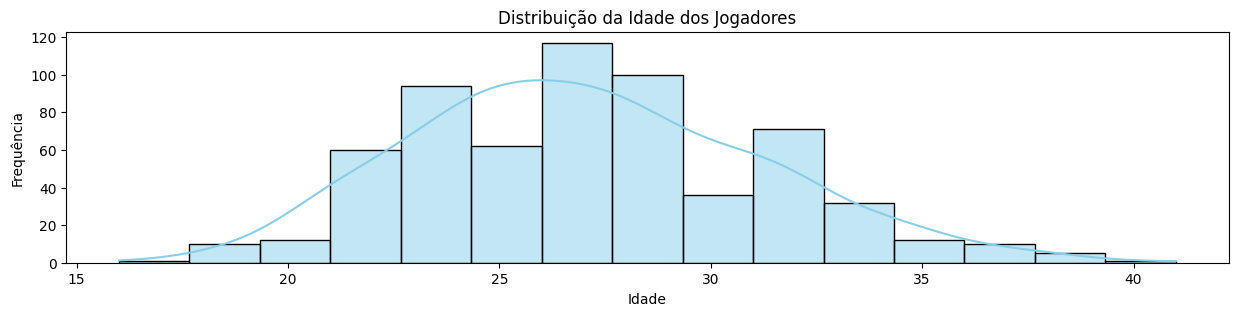

In [113]:
# Gráficos de Distribuição Idades
plt.figure(figsize=(15, 3))
sns.histplot(dataset['Age'], bins=15, kde=True, color='skyblue')
plt.title('Distribuição da Idade dos Jogadores')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

Adicionalmente, foi  utilizado um boxplot para comparar os valores de mercado dos jogadores agrupados por suas posições em campo. Essa visualização destacou:
1. A variabilidade dos valores de mercado em cada posição.
2. A presença de possíveis outliers, especialmente em posições como atacantes e meio-campistas, que frequentemente apresentam jogadores de alto valor de mercado.

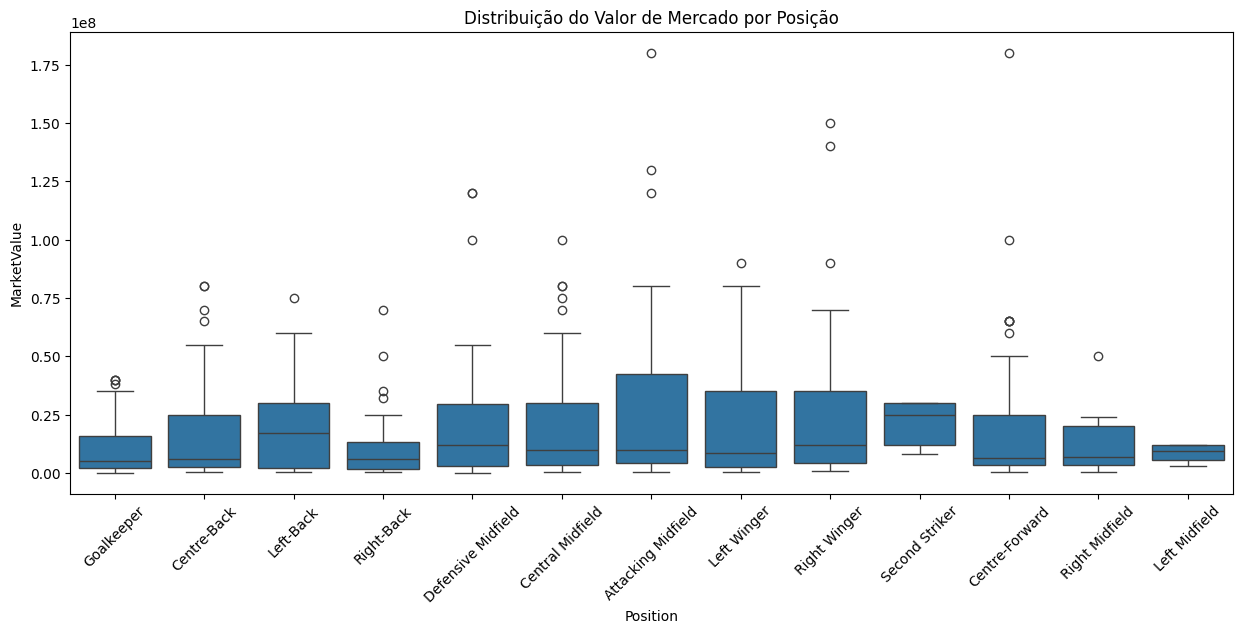

In [129]:
# Gráficos de Distribuição valor de mercado por posições
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataset, x='Position', y='MarketValue')
plt.title('Distribuição do Valor de Mercado por Posição')
plt.xticks(rotation=45)
plt.show()

Por fim, objetivando a  exploração das relações entre variáveis como idade, altura, partidas jogadas, gols e valor de mercado, foi gerado um mapa de calor (heatmap) de correlação. Os resultados mostraram:
1. Correlações positivas entre partidas jogadas e valor de mercado, indicando que jogadores mais experientes tendem a ter maior valorização.
2. Uma correlação moderada entre gols marcados e valor de mercado, particularmente relevante para atacantes.

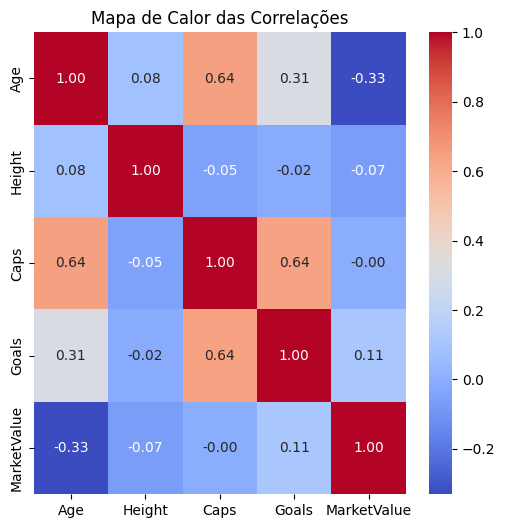

In [128]:
# Correlações entre variáveis numéricas
plt.figure(figsize=(6,6))
corr = dataset[['Age', 'Height', 'Caps', 'Goals', 'MarketValue']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor das Correlações')
plt.show()

# 4. Tratamento da Base de Dados

* Separe o dataset entre treino e teste (e validação, se aplicável).
* Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.
* Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.
* Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.

No caso do dataset utilizado, a separação entre treino e teste deve ser feita para garantir a capacidade de generalização dos modelos.

Como o dataset utilizado são dados de corte transversal (cross section), cujas estruturas de dados tabulares foram coletados em apenas um período no tempo, uma divisão aleatória torna-se adequada.

Isto posto, procedeu-se a separação seguindo o padrão 70-15-15 para treino, teste e validação.

In [161]:
# Separar variáveis independentes (X) e dependente (y)
X = dataset.drop(columns=["MarketValue", "Name", "Country", "Club"], errors="ignore")  # Remover colunas irrelevantes
Y = dataset["MarketValue"]

categorical_columns = ["Position", "Foot"]  # Colunas categóricas identificadas
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Dividir em treino, validação e teste (70%, 15%, 15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Tamanhos dos conjuntos:")
print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")

Tamanhos dos conjuntos:
Treino: (436, 19), Validação: (93, 19), Teste: (94, 19)


Uma vez que o conjunto de dados é limitado e a validação cruzada pode ajudar a avaliar a robustez de modelos alternativos, especialmente em etapas de seleção de atributos e ajuste de hiperparâmetros


In [164]:
# 2. Transformações de dados
# a) Padronização (Z-Score)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_val_standard = scaler_standard.transform(X_val)
X_test_standard = scaler_standard.transform(X_test)

# b) Normalização (0 a 1)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)
X_test_minmax = scaler_minmax.transform(X_test)

print("\nTransformações concluídas (padronização e normalização).")


Transformações concluídas (padronização e normalização).


# 5. Modelagem e Análise dos Resultados

**Modelagem e Treinamento**
* Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.
* Há algum ajuste inicial para os hiperparâmetros?
* O modelo foi devidamente treinado? Foi observado problema de underfitting?
* É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
* Há algum método avançado ou mais complexo que possa ser avaliado?
* Posso criar um comitê de modelos diferentes para o problema (ensembles)?

Dado que o problema envolve prever uma variável contínua (MarketValue), trata-se de um problema de regressão. Para este tipo de problema, os algoritmos mais indicados incluem: linear regression; decision trees; e random forest
Como o dataset não é extremamente grande e a relação entre as variáveis parece ter algum grau de não-linearidade, começaremos com modelos mais simples (como Linear Regression e Decision Trees). Após isso, avançaremos para modelos mais robustos (Random Forest).


In [165]:
# Treinar diferentes modelos
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
}

# Avaliar cada modelo
results = {}
for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train, Y_train)

    # Previsões
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Métricas
    train_rmse = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(Y_val, y_val_pred))
    train_r2 = r2_score(Y_train, y_train_pred)
    val_r2 = r2_score(Y_val, y_val_pred)

    # Armazenar resultados
    results[model_name] = {
        "Train RMSE": train_rmse,
        "Validation RMSE": val_rmse,
        "Train R2": train_r2,
        "Validation R2": val_r2
    }

# Exibir os resultados
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")


Linear Regression:
  Train RMSE: 21658963.4973
  Validation RMSE: 18031772.2289
  Train R2: 0.2551
  Validation R2: -0.0681

Decision Tree:
  Train RMSE: 17583891.9361
  Validation RMSE: 21967751.1108
  Train R2: 0.5091
  Validation R2: -0.5853

Random Forest:
  Train RMSE: 9982830.0278
  Validation RMSE: 17729806.5467
  Train R2: 0.8418
  Validation R2: -0.0326


1. A Regressão Linear: apresenta um desempenho muito limitado (underfitting).
O valor de R² no treino (0.2551) é baixo, indicando que o modelo explica apenas cerca de 25% da variação nos dados de treino. O R² negativo na validação (-0.0681) indica que o modelo não é capaz de generalizar para novos dados.
Com isso, o modelo de regressão não se mostra adequado para o problema, possivelmente devido à complexidade e não-linearidade dos dados.

2. Decision Tree: o R² no treino (0.5091) é maior que o da Regressão Linear, sugerindo que está capturando melhor a relação entre as variáveis.
Contudo, o desempenho no conjunto de validação é muito ruim (R² = -0.5853)indica possivel overfitting. O modelo se ajusta bem aos dados de treino, mas falha ao generalizar para dados desconhecidos (overfitting). O alto RMSE na validação reforça a ideia de overfitting.
Assim, o modelo precisa de regularização (limitação da profundidade, divisão mínima ou outros parâmetros) para reduzir o overfitting.

3. Random Forest: apresenta o menor RMSE no conjunto de treino (9,982,830) e um
R² alto (0.8418), indicando que o modelo ajusta bem os dados de treino. Contudo, o  R² na validação (-0.0326) é negativo, mostrando que o modelo ainda tem dificuldades em generalizar para novos dados (overfitting).
O RMSE na validação é menor do que os modelos anteriores, mas ainda é alto, indicando que o Random Forest é promissor, mas requer ajustes nos hiperparâmetros.
Isto posto, o modelo Random Forest é o modelo com maior potencial, mas ainda precisa de otimização para melhorar sua generalização.

Cada modelo possui hiperparâmetros básicos que podem ser ajustados inicialmente. Aqui estão os ajustes iniciais recomendados:

1. Regressão Linear: sem hiperparâmetros críticos para o ajuste inicial.

2. Decision Tree: max_depth (Controla a profundidade máxima da árvore para evitar overfitting); min_samples_split (Mínimo de amostras para dividir um nó).

3. Random Forest: n_estimators (Número de árvores no ensemble, inicialmente propusemos iniciar com 100); max_depth (Profundidade máxima das árvores); e max_features(Número máximo de features consideradas para cada divisão).

In [166]:
# Avaliar cada modelo com validação cruzada k-fold
k = 5  # Número de folds para validação cruzada
cv_results = {}

for model_name, model in models.items():
    # Calcular scores de validação cruzada para RMSE (neg_mean_squared_error)
    neg_mse_scores = cross_val_score(
        model, X_train, Y_train, cv=k, scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-neg_mse_scores)  # Converter MSE para RMSE

    # Armazenar os resultados
    cv_results[model_name] = {
        "Mean RMSE": np.mean(rmse_scores),
        "Std RMSE": np.std(rmse_scores),
        "RMSE Scores": rmse_scores
    }

# Exibir os resultados da validação cruzada
for model_name, metrics in cv_results.items():
    print(f"\n{model_name}:")
    print(f"  Mean RMSE: {metrics['Mean RMSE']:.4f}")
    print(f"  Std RMSE: {metrics['Std RMSE']:.4f}")
    print(f"  RMSE Scores: {metrics['RMSE Scores']}")


Linear Regression:
  Mean RMSE: 22611920.8329
  Std RMSE: 1995914.2024
  RMSE Scores: [25465812.05121676 21055705.06396722 24028971.85759356 22607140.56720403
 19901974.62442717]

Decision Tree:
  Mean RMSE: 25008171.1943
  Std RMSE: 1634448.0189
  RMSE Scores: [26781983.75055929 24915667.36403921 26906534.86486578 23527625.98285462
 22909044.00903651]

Random Forest:
  Mean RMSE: 23281852.8073
  Std RMSE: 1386159.2984
  RMSE Scores: [25078871.05092495 22222918.3104045  24842951.2212514  21835257.01033843
 22429266.4435034 ]


1. Linear Regression:
A RMSE média é mais baixa que a Decision Tree, mas ainda alta, indicando que o modelo linear é insuficiente para capturar toda a complexidade dos dados.
O desvio padrão é elevado (quase 2M), sugerindo que o modelo é sensível a diferentes divisões dos dados.
A Regressão Linear ainda apresenta desempenho limitado e não é a melhor escolha para este problema.

2. Decision Tree:
A RMSE média é mais alta que a Regressão Linear, indicando pior desempenho geral.
O desvio padrão é semelhante ao da Linear Regression, mostrando certa consistência entre os folds.
A Decision Tree provavelmente sofre de overfitting, pois sua performance em validação é inferior ao treino. Mesmo limitada a uma profundidade máxima de 5, ela não generaliza bem.
Embora fácil de interpretar, a Decision Tree não é adequada sem ajustes adicionais.

3. Random Forest
A RMSE média é a menor entre os três modelos, mostrando que o Random Forest é o mais eficaz em capturar padrões nos dados.
O desvio padrão é o menor (1.38M), indicando maior estabilidade e menor sensibilidade às divisões dos dados.
A Random Forest ainda apresenta espaço para otimização de hiperparâmetros (por exemplo, ajustando max_depth, n_estimators, etc.) para reduzir ainda mais o erro.
Assim, o Random Forest é o melhor modelo até agora, com bom equilíbrio entre desempenho e estabilidade.

In [168]:
# Definir os parâmetros a serem testados no Grid Search
param_grid = {
    "n_estimators": [100, 200, 300],  # Número de árvores
    "max_depth": [5, 10, 15, None],  # Profundidade máxima
    "min_samples_split": [2, 5, 10],  # Divisões mínimas de amostras em um nó
    "min_samples_leaf": [1, 2, 4],  # Número mínimo de amostras por folha
    "max_features": ["sqrt", "log2", None]  # Número máximo de features consideradas por divisão
}

# Configurar o modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Configurar o Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Usar erro quadrático médio negativo
    cv=5,  # Número de folds para validação cruzada
    verbose=2,
    n_jobs=-1
)

# Realizar o Grid Search nos dados de treino
grid_search.fit(X_train, Y_train)

# Recuperar os melhores parâmetros e o melhor desempenho
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Converter para positivo (MSE)
best_rmse = best_score ** 0.5  # Converter MSE para RMSE

print("Melhores parâmetros encontrados:", best_params)
print("Melhor RMSE obtido:", best_rmse)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Melhores parâmetros encontrados: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Melhor RMSE obtido: 22324981.79602988



Interpretação dos Resultados do Grid Search:
Foram avaliadas 324 combinações diferentes de hiperparâmetros usando validação cruzada com 5 folds, totalizando 1.620 ajustes individuais.

1. Hiperparâmetros avaliados:
* n_estimators: Número de árvores na floresta (100, 200, 300).
* max_depth: Profundidade máxima de cada árvore (5, 10, 15, None).
* min_samples_split: Número mínimo de amostras necessário para dividir um nó (2, 5, 10).
* min_samples_leaf: Número mínimo de amostras em cada folha (1, 2, 4).
* max_features: Número máximo de features consideradas em cada divisão (sqrt, log2, None).

2. Melhor Combinação de Hiperparâmetros Encontrado:
* max_depth = 10: Limita a profundidade das árvores para evitar overfitting e reduzir a complexidade do modelo.
* max_features = None: Considera todas as features disponíveis em cada divisão, o que permite árvores mais complexas.
* min_samples_leaf = 4: Cada folha (nó terminal) deve ter pelo menos 4 amostras, evitando divisões desnecessárias e melhorando a generalização.
* min_samples_split = 10: Um nó só será dividido se houver pelo menos 10 amostras, prevenindo divisões muito específicas que levam ao overfitting.
* n_estimators = 300: O modelo utiliza 300 árvores, aumentando a estabilidade e a robustez.

3. Métrica de Desempenho
O RMSE representa o erro médio nas previsões, em termos absolutos, com unidades da variável-alvo (MarketValue). Esse valor é mais baixo do que os obtidos pelos modelos anteriores, indicando uma melhoria na performance.
Ainda assim, o erro é alto, o que pode indicar grande variabilidade nos valores-alvo.

In [169]:
# Criar o modelo Random Forest com os melhores hiperparâmetros encontrados
optimized_rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=None,
    random_state=42
)

# Treinar o modelo otimizado com os dados de treino
optimized_rf_model.fit(X_train, Y_train)

# Fazer previsões no conjunto de validação
y_val_pred = optimized_rf_model.predict(X_val)

# Avaliar o modelo otimizado
val_rmse = np.sqrt(mean_squared_error(Y_val, y_val_pred))
val_r2 = r2_score(Y_val, y_val_pred)

# Exibir os resultados
print("Avaliação do Modelo Otimizado:")
print(f"RMSE no conjunto de validação: {val_rmse:.2f}")
print(f"R² no conjunto de validação: {val_r2:.4f}")

Avaliação do Modelo Otimizado:
RMSE no conjunto de validação: 17206523.86
R² no conjunto de validação: 0.0274


Apesar de melhorias no RMSE com os hiperparâmetros otimizados, o desempenho geral do modelo permanece limitado, com R² baixo. O problema pode exigir dados mais ricos ou modelos avançados para capturar a complexidade da relação entre as variáveis preditoras e os valores de mercado.

#CONCLUSÃO

O objetivo deste trabalho foi desenvolver um modelo preditivo capaz de estimar o valor de mercado de atletas com base em variáveis como idade, posição, altura e histórico na seleção. Utilizando diferentes algoritmos de aprendizado de máquina, como Regressão Linear, Decision Tree e Random Forest, este último ainda foi otimizado por meio de ajuste de hiperparâmetros via Grid Search.

Apesar das melhorias obtidas, o desempenho do modelo foi limitado pelas seguintes razões:

* Ausência de Dados Estatísticos Detalhados: O valor de mercado de um atleta é influenciado por métricas que não estão presentes no dataset atual, como:
Estatísticas individuais de desempenho em competições (gols, assistências, passes decisivos); participação em grandes torneios (Liga dos Campeões, Copas do Mundo); avaliação de desempenho físico e técnico recente.
Esses fatores têm um impacto direto na percepção de mercado e, consequentemente, no valor do atleta.

* Alta Variabilidade na Variável-Alvo (MarketValue): valores de mercado variam amplamente, muitas vezes influenciados por fatores externos (popularidade do clube, demanda específica do mercado de transferências, expectativas futuras sobre o potencial do atleta).

* Possível Presença de Outliers: a análise exploratória revelou possíveis valores extremos em MarketValue, que distorcem os resultados do modelo e aumentam o erro médio.

A incorporação de dados estatísticos detalhados de competições prévias é essencial para capturar a complexidade que define o valor de mercado de um atleta. Sem esses dados, os modelos de aprendizado de máquina permanecem limitados em sua capacidade preditiva, como demonstrado pelos baixos valores de
R² obtidos neste estudo. Assim, uma base de dados mais robusta, combinada com técnicas avançadas de modelagem, tem o potencial de gerar estimativas significativamente mais precisas e úteis para stakeholders do mercado esportivo.

Caso haja interesse em expandir este estudo, a construção ou integração de datasets mais completos é uma prioridade. Modelos avançados, como Gradient Boosting ou Redes Neurais, também podem ser explorados para aproveitar plenamente os dados adicionais.